# Project: LSTM_module

LSTM을 활용한 보이스피싱 탐지 모듈 개발

## 순서
1. import: 필요한 모듈 import
2. 데이터 셋 불러오기(load)
2. 전처리: 학습에 필요한 데이터 전처리 수행
3. 모델링(model): 모델 정의
4. 컴파일(compile): 모델 생성
5. 학습(fit): 모델 학습

## 모듈 import

In [224]:
import os

import json
import pickle
import re

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 파일 이름 선언

필요 변수, 모델, 토큰 객체 등 파일 이름 선언

In [225]:
file_name = "LSTM_module_ver4.0"

## 데이터 셋 불러오기

빈 list 생성

In [226]:
spam_X = []
spam_temp = []
ham_X = []
ham_temp = []

* `ham_count`: 일반 데이터 개수 제한
* `min_data`: 텍스트 데이터 최소 길이
* `data_length`: 텍스트 데이터 일반 길이

In [227]:
ham_count = 10000
min_data = 10
data_length = 100

보이스피싱 통화 데이터 가져오기

In [228]:
path = 'fraudDataset/spamData/'
path1 = os.listdir(path)
for a in path1:
    path2 = path+a
    with open(path2, 'r', encoding='utf-8') as f:
        contents = f.read()
        contents = re.sub("\n"," ",contents)
        contents = re.sub("사회자 :|피해자 :|\((.+?)\)|네|[^가-힣 ]", "", contents) # 특수문자 제거
        spam_temp.append(contents)

일반 통화 데이터 가져오기

In [229]:
contents = ""
path = 'fraudDataset/hamData_counselor/'
path1 = os.listdir(path)
for a in path1:
    
    if len(ham_temp) > ham_count:
        break
    
    path2 = os.listdir(path+a)
    for b in path2:
        
        if len(ham_temp) > ham_count:
            break
        
        path3 = os.listdir(path+a+'/'+b)
        for c in path3:
            
            if len(ham_temp) > ham_count:
                break
                    
            path4 = os.listdir(path+a+'/'+b+'/'+c)
            for d in path4:
                
                if len(ham_temp) > ham_count:
                    break
                
                path5 = os.listdir(path+a+'/'+b+'/'+c+'/'+d)
                for e in path5:
                    
                    if len(ham_temp) > ham_count:
                        break
                    
                    path6 = os.listdir(path+a+'/'+b+'/'+c+'/'+d+'/'+e)

                    if len(contents) > min_data:
                        ham_temp.append(contents)

                    contents = ""
                    for f in path6:
                        
                        if len(ham_temp) > ham_count:
                            break
                        
                        if f.split(".")[1] == "txt":
                            path7 = path+a+'/'+b+'/'+c+'/'+d+'/'+e+'/'+f
                        else:
                            continue
                        with open(path7, "r", encoding="UTF-8") as f:
                            text = f.read()
                            text = re.sub("\n"," ",text)
                            text = re.sub("#@(.+?)#|네|[^가-힣 ]", "", text) # 특수문자 제거

                        contents += text+" "
                        if len(contents) > data_length:
                            ham_temp.append(contents)
                            contents = ""
                            
ham_X = ham_temp

피싱 데이터 1개 출력

In [230]:
spam_temp[0]

'예 누구라고요 서울중앙지검이라고요 검찰청입니다   본인 그 명의저용 사건 관련해서 몇 가지만 사실 확인차 연락을 드린 겁니다  잠시 통화는 괜찮습니까   본인 혹시 그 서울 노원구 출신인 이창배라고 혹시 알고 계십니까  이창배라고 혹시 알고 계십니까 이창씨 여 들어본 것 같은데요 어디서 들어보셨어요 어 어서 제 아는 사람 중에 하나 있는 것 같은데  예 그 아이가 어떤 지십니까 나이가 지금 몇 살이 됐지 한 열 십 된 걸로 알고 있는데요  대요 예예 열여덟 살 저는 삼십구세 남성을 말씀드리는 겁니다  그래요 거기 아닌가 본데요 그럼 이 사람 전직 농협은행 직원이었습니다 그리고 세 남성이고요   왜냐하면은 저희 수사 기관에서 이창배를 중심으로 한 금융범죄 사기단을 권고를 했습니다 다 검거 당시 다량의 대포통장과 위조된 신분증을 압수 했습니다 그중에서 본인 명의로 된 농협은행 통장이랑 신한은행 통장 주점이 같이 발견이 되었습니다  신한은행도 발견됐어요  농협은행 신한은행입니다 신한은행 거래 안 한 지 오래됐는데 저는 뭐 김 본인께서 거래하고 계시는 은행권을 여쭤보는 게 아니라 저희가 압수한 대포통장에 대해서 말씀을 드리고 있는 겁니다   언제 개설이 되셨냐면 년 월 일 서울 노원구에 있는 불암지점이랑 중계동 지점에서 개설이 되셨거든요   본인께서 직접 개설하신 계좌가 아니라는 말씀이신 거죠  그렇죠 저는 신한은행을 들어가 본 적이 없어가지고요  혹시 본인 대포통장이 어떤 건지는 알고 계십니까  대프가 저기 큰 거 아닌가요 어떤 거요  큰 통장이라고 말씀하는 게 아니라 이 범죄자들이 다른 사람 명의를 도용을 해서 통장을 불법적으로 개설을 하는 겁니다  그리고 그 통장을 가지고 사기를 치는 거죠  그래서 그 큰 금액만 들어가는 통장이  대포 통장 아니야 사기를 치는 통장이 범죄에 이용하는 게 대포 통장입니다  그게 대포통장이구나   지금 본인 명의의 통장으로 인해서 다시 피해자분들이 발생한 사건이고요    이창가라는 사람이 진술했을 때는 어떤 사람들은 총장 돈을 통

일반 데이터 5개 출력

In [231]:
ham_temp[:5]

['그럼 기기가 등록되었나 확인 부탁드립니다 다른 문의사항 더 없으십니까  그러셨군요 아 여기 설명 보니까 메인 기기 하나를 등록하고 결제를 진행한 후에 나머지 기기 추가가 가능하다고 되어있요 그럼 그렇게 하면 될 것 같아요 ',
 '아 그렇군요 그럼 지금 전화 통화하면서 기기 등록할게요 기기 등록은 제가 직접 접 하면 되는 건가요 아니면 혹시 원격으로 도와주시기도 하나요  빨리 좀 부탁드려요 제가 여기 전화드리기 전에 챗봇 상담에 먼저 카톡을 보냈었거든요 한국어학원 요즘 고객센터 연결도 잘 안 되고 코로나로 상담시간 단축해서 챗봇으로 웬만한 건 다 해결할 수 있다고 해서 그냥 챗봇에 먼저 문의 카톡 보냈었는데 챗봇에 기본으로 탑재되어있는 설명 목록 어 뭐라고 설명을 드려야 하지 ',
 ' 그럼 제가 지금 진행할게요 기기 등록은 하나만 가능한가요 아이디랑 계정 당 하나씩만 가능한가요 제가 평소에 집에서는 노트북이나 피씨로 들을 건데 밖에 나가는 경우에는 모바일이나 태블릿 피씨로 들을 거 같은데 그럼 적어도 기기를 개 개는 등록해야 하는 건가요 ',
 '어 지금 팝업창 클릭해봤는데 이미 설치된 프로그램이라고 덮어 씌우거나 기존에 설치되었는 프로그램을 삭제하고 다시 설치하겠냐는 문구가 뜨요 그건 이미 프로그램이 설치되어있는 거 아닌가요 그럼 설치 관련 문제는 아닌 거 같은데요 ',
 '설치가 되어있을 텐데 여기 한국어학원에서만 단독으로 쓰는 결제 프로그램은 아닐 거잖아요 다른 쇼핑몰이나 플랫폼에서 결제할 때 프로그램 결제한 적 있는 것 같은데 어떤 설치 프로그램 말씀하시는 거죠 인강 스트리밍이나 다운로드할 때 필요한 프로그램 말씀하시는 건가요 그거라면 전부 설치했던 것 같은데요 ']

## 텍스트 데이터 분리

**findIndex**: 문장이 끝나는 부분의 index값을 찾기위한 함수

In [232]:
def findIndex(data_list, split_list, start_index):
    index_list = []
    for i in split_list:
        index = data_list.find(i, start_index)
        index_list.append(index)
        
    index_list = [i for i in index_list if i not in [-1]]
    if index_list == []:
        return -1
    
    index = min(index_list)
    
    return index     

* `split_list`: 문장 단위로 분리하기 위한 글자 리스트

In [233]:
split_list = ['다 ','요 ','죠 ', '까 ']

`data_length` 값 이후에 `split_list` 에 있는 문자가 나오면 자르기 (스팸 데이터)

In [234]:
for t in spam_temp:
    index = findIndex(t, split_list, data_length)
        
    i = 0
    while index != -1:
        x = t[i:index+2]
        spam_X.append(x)
        
        i = index+2
        index = findIndex(t, split_list, i+data_length)
    else:
        x = t[i:]
        if len(x) > min_data:
            spam_X.append(x) # 텍스트 마지막 부분 추가

## 전처리: 데이터 길이 제한

길이가 min 미만 데이터 삭제 후 중복 제거

In [235]:
spam_df = pd.DataFrame(spam_X, columns=['text'])
spam_df.drop(spam_df[spam_df['text'].str.len() < min_data].index, inplace=True) # 길이가 min_data 미만인 데이터 삭제
spam_df.shape[0] - spam_df['text'].nunique() # 중복 개수

54

In [236]:
ham_df = pd.DataFrame(ham_X, columns=['text'])
ham_df.drop(ham_df[ham_df['text'].str.len() < min_data].index, inplace=True) # 길이가 min_data 미만인 데이터 삭제
ham_df.shape[0] - ham_df['text'].nunique() # 중복 개수

564

In [237]:
spam_df.drop_duplicates(subset=['text'], inplace=True) # 중복 제거
spam_df['label'] = 1

spam_df

,text,label
0,예 누구라고요 서울중앙지검이라고요 검찰청입니다 본인 그 명의저용 사건 관련해서 ...,1
1,이창배라고 혹시 알고 계십니까 이창씨 여 들어본 것 같은데요 어디서 들어보셨어요 ...,1
2,대요 예예 열여덟 살 저는 삼십구세 남성을 말씀드리는 겁니다 그래요 거기 아닌가...,1
3,다 검거 당시 다량의 대포통장과 위조된 신분증을 압수 했습니다 그중에서 본인 명의로...,1
4,신한은행 거래 안 한 지 오래됐는데 저는 뭐 김 본인께서 거래하고 계시는 은행권을 ...,1
...,...,...
4309,예 저는 다른 피해자분들 계속 도움을 드려야 되요 일단은 그럼 분 뒤에 다시 전...,1
4310,메모지를 찾아봐야 되거든요 아니면 제가 은행 가서 물어 봐야 될 수도 있고요 제...,1
4311,일단 제가요 은행에도 물어봐야 이 지금 내가 전화를 해가 다시 은행에 물어보고 ...,1
4312,저희가 분 뒤에 연락드려도 제가 연결이 안 될 거예요 그러시고 본인이 지금 말씀해...,1


In [238]:
ham_df.drop_duplicates(subset=['text'], inplace=True) # 중복 제거
ham_df['label'] = 0

ham_df

,text,label
0,그럼 기기가 등록되었나 확인 부탁드립니다 다른 문의사항 더 없으십니까 그러셨군요 ...,0
1,아 그렇군요 그럼 지금 전화 통화하면서 기기 등록할게요 기기 등록은 제가 직접 접 ...,0
2,그럼 제가 지금 진행할게요 기기 등록은 하나만 가능한가요 아이디랑 계정 당 하나씩...,0
3,어 지금 팝업창 클릭해봤는데 이미 설치된 프로그램이라고 덮어 씌우거나 기존에 설치되...,0
4,설치가 되어있을 텐데 여기 한국어학원에서만 단독으로 쓰는 결제 프로그램은 아닐 거잖...,0
...,...,...
9996,남 씨가 영어 영상 전화로 회화 배우는 거 맞죠 감사합니다 자녀 중 한 분만...,0
9997,있습니다 감사해요 아 그럼 개월삼 개월 미리 하면 결제금액이 얼마인가요 저번에...,0
9998,그건 그냥 그 프로그램 신청할 때 구운몽 학습지 회원이라고 고객센터에 전화해서 말...,0
9999,자녀들 이름이요 아님 학습지 등록한 사람인 제 이름을 말해야 하나요 혹시 다른 ...,0


데이터 정보 출력

In [239]:
print("스팸 데이터 개수 : {}(read) -> {}(drop)".format(len(spam_X),len(spam_df)))
print('스팸 데이터 최소 길이',len(min(spam_df['text'], key=len)))
print('스팸 데이터 최대 길이',len(max(spam_df['text'], key=len)))
print('----------------------------------------------------')
print("일반 데이터 개수 : {}(read) -> {}(drop)".format(len(ham_X),len(ham_df)))
print('일반 데이터 최소 길이',len(min(ham_df['text'], key=len)))
print('일반 데이터 최대 길이',len(max(ham_df['text'], key=len)))

스팸 데이터 개수 : 4314(read) -> 4260(drop)
스팸 데이터 최소 길이 11
스팸 데이터 최대 길이 404
----------------------------------------------------
일반 데이터 개수 : 10001(read) -> 9437(drop)
일반 데이터 최소 길이 11
일반 데이터 최대 길이 275


스팸 / 일반 데이터 합치기

In [240]:
total_df = pd.concat([spam_df, ham_df], ignore_index=True)

In [241]:
total_df

,text,label
0,예 누구라고요 서울중앙지검이라고요 검찰청입니다 본인 그 명의저용 사건 관련해서 ...,1
1,이창배라고 혹시 알고 계십니까 이창씨 여 들어본 것 같은데요 어디서 들어보셨어요 ...,1
2,대요 예예 열여덟 살 저는 삼십구세 남성을 말씀드리는 겁니다 그래요 거기 아닌가...,1
3,다 검거 당시 다량의 대포통장과 위조된 신분증을 압수 했습니다 그중에서 본인 명의로...,1
4,신한은행 거래 안 한 지 오래됐는데 저는 뭐 김 본인께서 거래하고 계시는 은행권을 ...,1
...,...,...
13692,남 씨가 영어 영상 전화로 회화 배우는 거 맞죠 감사합니다 자녀 중 한 분만...,0
13693,있습니다 감사해요 아 그럼 개월삼 개월 미리 하면 결제금액이 얼마인가요 저번에...,0
13694,그건 그냥 그 프로그램 신청할 때 구운몽 학습지 회원이라고 고객센터에 전화해서 말...,0
13695,자녀들 이름이요 아님 학습지 등록한 사람인 제 이름을 말해야 하나요 혹시 다른 ...,0


## Train / Validation Set 분리

0.75 : 0.25 비율로 나누기

In [242]:
train_data, test_data = train_test_split(total_df, test_size = 0.25, random_state = 42) # 훈련용 테스트 데이터 나누기
#train_data, test_data = train_test_split(total_df, test_size = 0.25, shuffle = False) # 훈련용 테스트 데이터 나누기

훈련 / 테스트 데이터 개수 출력

In [243]:
print('데이터 총 개수 :',len(total_df))
print('훈련용 데이터 개수 :', len(train_data))
print('테스트용 데이터 개수 :', len(test_data))

데이터 총 개수 : 13697
훈련용 데이터 개수 : 10272
테스트용 데이터 개수 : 3425


스팸 / 일반 데이터 개수 그래프 비교

   label  count
0      0   6012
1      1   4260


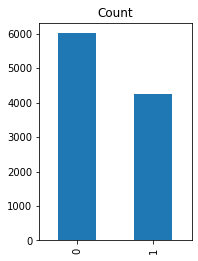

In [244]:
plt.subplot(121)
train_data['label'].value_counts().plot(kind = 'bar', title='Count')
print(train_data.groupby('label').size().reset_index(name = 'count'))

## 전처리: 빈 데이터 처리

빈 데이터 NA 처리

In [245]:
pd.set_option('mode.chained_assignment', None) # 경고 메시지 끄기

train_data.replace('', np.nan, inplace=True)

In [246]:
test_data.replace('', np.nan, inplace=True)

전처리 후 생긴 null 데이터 확인

In [247]:
print(train_data.isnull().sum()) # null 데이터 확인
print()
print(test_data.isnull().sum())

text     0
label    0
dtype: int64

text     0
label    0
dtype: int64


null 값이 있는 행 제거 후 확인

In [248]:
train_data = train_data.dropna(how='any', axis=0)
test_data = test_data.dropna(how='any', axis=0)

print(train_data.isnull().sum()) # null 데이터 확인
print()
print(test_data.isnull().sum())

text     0
label    0
dtype: int64

text     0
label    0
dtype: int64


## 전처리: 토큰화

Okt 객체 선언

In [249]:
okt = Okt() # 한글은 형태소 분석기 사용해야됨 KoNPLY

불용어 단어

In [250]:
stopwords = [] # spam, ham 빈도 수 높은 중복단어 제거

어간 단위로 토큰화 및 불용어 처리

In [251]:
X_train = []
for sentence in train_data['text']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 처리
    X_train.append(temp_X)

In [252]:
X_test = []
for sentence in test_data['text']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 처리
    X_test.append(temp_X)

Dataframe 새 Column에 추가

In [253]:
train_data['tokenized'] = X_train
test_data['tokenized'] = X_test

## 단어별 빈도 수 확인

스팸 단어 빈도 확인

In [254]:
spam_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
spam_word_count = Counter(spam_words)
print(spam_word_count.most_common(20))

[('하다', 7503), ('이', 6769), ('에', 4444), ('가', 4362), ('사', 3885), ('기범', 3734), ('을', 3512), ('되다', 3444), ('본인', 3320), ('있다', 3195), ('를', 2422), ('거', 2335), ('지금', 2071), ('예', 1862), ('그', 1788), ('으로', 1682), ('제', 1621), ('아니다', 1532), ('은', 1457), ('는', 1447)]


일상 단어 빈도 확인

In [255]:
ham_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
ham_word_count = Counter(ham_words)
print(ham_word_count.most_common(20))

[('하다', 14561), ('이', 8096), ('가', 5686), ('있다', 5629), ('에', 5045), ('되다', 4573), ('을', 4298), ('를', 3270), ('요', 3166), ('그렇다', 3101), ('거', 2983), ('도', 2939), ('제', 2827), ('는', 2567), ('은', 2342), ('같다', 2288), ('로', 2208), ('것', 2109), ('으로', 2048), ('아', 2002)]


Dataframe 값 추출

In [256]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

## 정수 인코딩

`vocab_size`의 값을 정하기 위한 토큰화 객체 생성

In [257]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

최소 단어 빈도 수 제한

In [258]:
threshold = 2 # 등장 횟수가 threshold미만인 단어는 제거

최적의 `vocab_size` 선정

In [259]:
word_to_index = tokenizer.word_index
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 2
print('vocab_size :',vocab_size)

단어 집합(vocabulary)의 크기 : 9538
등장 빈도가 1번 이하인 희귀 단어의 수: 2969
단어 집합에서 희귀 단어의 비율: 31.128119102537223
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.595452977465444
vocab_size : 6571


단어 토큰화
* `num_words`: 단어 max 사이즈 지정. 빈도수가 높은 순으로 저장.
* `oov_token`: 단어 토큰에 없는 단어 표기법 지정

In [260]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'OOV')

`fit_on_texts`로 학습할 문장에 대한 토큰화 진행

In [261]:
tokenizer.fit_on_texts(X_train)

In [262]:
for key, value in tokenizer.word_index.items():
    if len(key) < 4:
        print('{}\t======>\t {}'.format(key, value))
    else:
        print('{}======>\t {}'.format(key, value))
    if value == 25:
        break

OOV	======>	 1
하다	======>	 2
이	======>	 3
가	======>	 4
에	======>	 5
있다	======>	 6
되다	======>	 7
을	======>	 8
를	======>	 9
거	======>	 10
요	======>	 11
그렇다	======>	 12
제	======>	 13
사	======>	 14
는	======>	 15
도	======>	 16
은	======>	 17
기범	======>	 18
으로	======>	 19
로	======>	 20
본인	======>	 21
지금	======>	 22
아	======>	 23
없다	======>	 24
같다	======>	 25


토큰화된 단어 사전의 개수

In [263]:
len(tokenizer.word_index)

9539

문장을 토큰으로 치환

In [264]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

변환된 Sequences 확인

In [265]:
X_train[:5]

[[36,
  946,
  319,
  238,
  59,
  658,
  423,
  85,
  1668,
  720,
  39,
  21,
  27,
  137,
  57,
  977,
  84,
  224,
  2,
  191,
  136,
  42,
  274,
  40,
  253,
  113,
  8,
  33,
  222,
  221,
  295,
  15,
  320,
  21,
  55,
  27,
  418,
  2563,
  862,
  111,
  2564,
  198,
  55,
  154,
  63,
  206],
 [2564,
  198,
  55,
  154,
  63,
  206,
  4615,
  169,
  563,
  64,
  34,
  29,
  25,
  835,
  64,
  34,
  122,
  3740,
  13,
  48,
  178,
  141,
  5,
  127,
  6,
  29,
  25,
  36,
  27,
  89,
  4,
  50,
  315,
  647,
  4,
  22,
  191,
  1525,
  66,
  2,
  696,
  223,
  7,
  133,
  20,
  154,
  63,
  6],
 [3428,
  36,
  36,
  696,
  1333,
  389,
  57,
  15,
  593,
  1,
  798,
  8,
  214,
  222,
  12,
  283,
  26,
  34,
  12,
  3,
  178,
  1851,
  231,
  97,
  281,
  39,
  86,
  313,
  798,
  3,
  238,
  1357,
  17,
  35,
  264,
  1088,
  30,
  2564,
  9,
  1801,
  19,
  2,
  128,
  338,
  14,
  1077,
  8,
  4079,
  9,
  2],
 [54,
  381,
  1033,
  2261,
  46,
  600,
  124,
  2565,
  7,


`vocab_size`보다 떨어지는 단어는 1로 치환 (OOV)

## 패딩
리뷰 길이

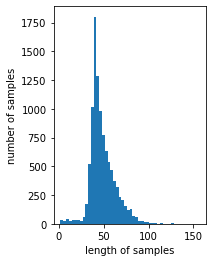

최대 길이 : 156
평균 길이 : 48.54088785046729


In [266]:
plt.subplot(122)
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('최대 길이 :',max(len(l) for l in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))

3가지 옵션 입력
* `maxlen`: 최대 문장 길이 정의. 길면 잘라냄
* `truncating`: 문장 길이가 `maxlen`보다 길 때, 앞을 자를지 뒤를 자를지 정의
* `padding`: 문장 길이가 `maxlen`보다 짧을 때, 앞을 채울지 뒤를 채울지 정의

In [267]:
max_len = 100 # 최대 길이 (그래프를 보고 판단)
trunc_type = 'post' # 잘라낼 문장의 위치
padding_type = 'post'

문장 길이 비율 찾기

In [268]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
    
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 99.65926791277259


In [269]:
X_train = pad_sequences(X_train, maxlen = max_len, truncating = trunc_type, padding = padding_type)
X_test = pad_sequences(X_test, maxlen = max_len, truncating = trunc_type, padding = padding_type)

변화된 후 shape 확인

In [270]:
X_train.shape

(10272, 100)

## 모델 정의

임베딩 차원 정의

In [271]:
embedding_dim = 100

모델 구성

In [272]:
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    LSTM(128, return_sequences = True),
    LSTM(128, return_sequences = True),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

## 컴파일

~~1. `optimizer`은 가장 최적화가 잘되는 알고리즘 'adam' 사용~~  
2. `loss`는 이진분류이므로, `binary_crossentropy` 사용

In [273]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

## ModelCheckpoint

val_acc 기준으로 epoch 마다 최적의 모델을 저장하기 위한 체크포인트 설정

In [274]:
mc = ModelCheckpoint(file_name+'.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

## EarlyStopping

val_loss 기준으로 4번까지 Overfitting(과적합)이 진행되면 자동으로 종료

In [275]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

## 모델 학습

In [276]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
33/33 [==============================] - 6s 61ms/step - loss: 0.7080 - acc: 0.5155 - val_loss: 0.2474 - val_acc: 0.9328

Epoch 00001: val_acc improved from -inf to 0.93285, saving model to LSTM_module_ver4.0.h5
Epoch 2/15
33/33 [==============================] - 1s 33ms/step - loss: 0.1980 - acc: 0.9479 - val_loss: 0.0462 - val_acc: 1.0000

Epoch 00002: val_acc improved from 0.93285 to 1.00000, saving model to LSTM_module_ver4.0.h5
Epoch 3/15
33/33 [==============================] - 1s 35ms/step - loss: 0.0812 - acc: 0.9806 - val_loss: 0.0379 - val_acc: 0.9922

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/15
33/33 [==============================] - 1s 35ms/step - loss: 0.0707 - acc: 0.9862 - val_loss: 0.0171 - val_acc: 0.9951

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/15
33/33 [==============================] - 1s 33ms/step - loss: 0.0886 - acc: 0.9792 - val_loss: 0.1569 - val_acc: 0.9976

Epoch 00005: val_acc did not improve from 1.00000
Epoch 6

학습 완료 후 `load_model` 를 해주지 않으면 ModelCheckpoint를 만든 의미가 없음

In [277]:
model = load_model(file_name+'.h5')

## 학습 오차 시각화

108/108 [==============================] - 2s 5ms/step - loss: 0.0486 - acc: 0.9991

 테스트 정확도: 0.9991


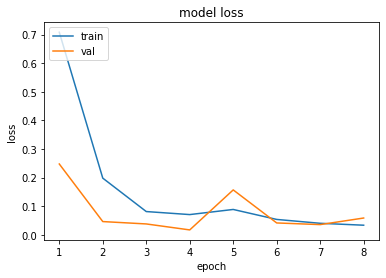

In [278]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

## 파일 저장

tokenizer 객체 저장

In [279]:
with open(file_name+"_tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

변수 저장

In [280]:
d = {'min_data':min_data, 'data_length':data_length, 'split_list':split_list,'max_len':max_len, 'trunc_type':trunc_type, 'padding_type':padding_type}
json_var = json.dumps(d)
with open(file_name+'_variable.json', 'w') as f:
    f.write(json_var)

불용어 단어 저장

In [281]:
json_stopwords = json.dumps(stopwords)
with open(file_name+'_stopwords.json', 'w') as f:
    f.write(json_stopwords)